# Importing Libraries
> `OpenCV` is not used.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
#import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as Image
from tensorflow.keras.applications import VGG19
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

Text(0.5, 1.0, 'Raw Image')

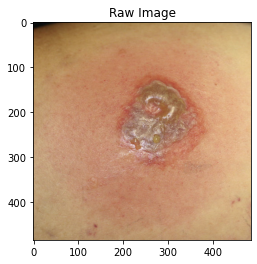

In [3]:
root = "./"
img = io.imread(root + "RashData/Lyme_Positive_By_Diease/EMRash/erythema migrans42.jpg")
plt.imshow(img)
plt.title("Raw Image")

In [4]:
HEIGHT, WIDTH = 300, 300
resized_img = resize(img, (HEIGHT, WIDTH))
plt.imshow(resized_img)
plt.title("Resized Image")

# Importing the data
1. Loading the data from root directory
2. Each image is resized into `200 * 200` dimension
3. The imported image is converted into an numpy array
4. Each data is normalized

In [ ]:
# Creating the dataset for processing -- Using SKIMAGE
path_root = root + "RashData/Train/Train_2_Cases"
data = []
categories = ["Negative", "Positive"]
flag = True
for category in categories:
    path = os.path.join(path_root, "Lyme_" + category)
    label = categories.index(category)
    
    for img in os.listdir(path):
        try:
            img_path = os.path.join(path, img)
            dis_img = io.imread(img_path)
            if flag:
                print(type(dis_img))
                flag = False
    
            image = resize(dis_img, (HEIGHT, WIDTH))
#             image = np.array(dis_img).flatten()
            data.append([image, label])
        except Exception as e:
            print("Could not add image.")

# Spliting the data array into -
* Image Feature Vector(image_ds)
* Corresponding Labels(labels)

In [6]:

image_ds = np.array([obj[0][:,:,0] for obj in data])
labels = np.array([obj[1] for obj in data])
print(image_ds.shape)
#image_ds = image_ds.reshape((356, 200, 200, 1))
len(labels[labels == 1])

# Creating Train and Test Data
> Using 20 percent of data as the test data.

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(image_ds, labels, test_size=0.20, shuffle=True)
print("Size of training data:", train_x.shape)
print("Size of test data:", test_x.shape)
len(train_y[train_y==1])

# Using Support Vector Machine for Trainning:
1. The training and testing data is flattened
2. Model is defined with a `Polynomial` kernel
3. Model is trained 
4. Confusion Matrix and Classification Report is observed

In [ ]:
train_x_flat = train_x.reshape((train_x.shape[0], HEIGHT * WIDTH))
test_x_flat = test_x.reshape((test_x.shape[0], HEIGHT * WIDTH))
print(train_x_flat.shape)
model_svm = SVC(kernel='poly', gamma='auto')
model_svm.fit(train_x_flat, train_y)

In [ ]:
pred_y = model_svm.predict(test_x_flat)
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

# Using Deep Feed Forward Network to train
+ Using a fully connected network to train 
+ The network consists of two hidden layer of size `20000 * 1`
+ Finally using a output layer with `sigmoid` activation as it is binary classification
> Assuming the input images are of dimension `100 * 100`.

In [ ]:
# model_dense = keras.models.Sequential([
#     keras.Input(shape=(100 * 100,)),
#     keras.layers.Dense(2 * 100 * 100, activation='relu'),
#     keras.layers.Dense(2 * 100 * 100, activation='relu'),
#     keras.layers.Dense(1)
# ])
# model_dense.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model_dense.fit(train_x_flat, train_y, batch_size=32, epochs=20,steps_per_epoch=4)

In [ ]:
# report = model_dense.evaluate(test_x_flat, test_y)
# print(report)

# Using CNN to train
This is executed in following steps:
1. First we rescale the training and validation data in range `[0, 1]`
2. Then we define 5 convolution layers with MaxPool layers and `relu` activation
3. Last output layer is of size 1 and using `sigmoid` activation function

In [79]:
train = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

train_ds = train.flow_from_directory(root + "RashData/Train/Train_2_Cases", target_size=(HEIGHT, WIDTH),
                                    batch_size=10, class_mode='binary')
val_ds = validation.flow_from_directory(root + "RashData/Validation/Validation_2_Cases", target_size=(HEIGHT, WIDTH),
                                       batch_size=10, class_mode='binary')
val_ds.class_indices
filter_size = (2, 2)
epochs = 25

In [80]:
model_conv_2d = keras.models.Sequential([
    keras.layers.Conv2D(32, filter_size, activation='relu', input_shape=(HEIGHT, WIDTH, 3), kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(64, filter_size, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(128, filter_size, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(256, filter_size, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(512, filter_size, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dense(1, activation='sigmoid')
])

In [81]:
model_conv_2d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_conv_2d = model_conv_2d.fit(train_ds, steps_per_epoch=3, epochs=epochs, validation_data=val_ds)

In [82]:
plt.figure(figsize=(20, 10))

epochs_range = range(1, epochs + 1)
train_loss = history_conv_2d.history['loss']
val_loss = history_conv_2d.history['val_loss']
# train_auc = history.history['auc']
# val_auc = history.history['val_auc']

# plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, train_auc, label="Training AUC", color='b')
# plt.plot(epochs_range, val_auc, label="Validation AUC", color='r')

# plt.xlabel("Epoch")
# plt.ylabel("AUC")
# plt.title("Training and Validation AUC")
# plt.legend()

plt.show()

## Using different state of the art models
+ VGG19
+ ResNet

In [9]:
DIMS_VGG = (224, 224, 3)
train_vgg = train.flow_from_directory(root + "RashData/Train/Train_2_Cases", target_size=(DIMS_VGG[0], DIMS_VGG[1]),
                                    batch_size=10, class_mode='binary')
val_vgg = validation.flow_from_directory(root + "RashData/Validation/Validation_2_Cases", 
                                         target_size=(DIMS_VGG[0], DIMS_VGG[1]), batch_size=10, class_mode='binary')


In [13]:
BATCH_SIZE = 16
STEP_SIZE_TRAIN = train_vgg.n // train_vgg.batch_size
STEP_SIZE_VAL = val_vgg.n // val_vgg.batch_size
EPOCH_VGG = 30

In [14]:
vgg = VGG19(input_shape=DIMS_VGG, weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = keras.layers.Flatten()(vgg.output)
hidd1 = keras.layers.Dense(1024, activation='relu')(x)
pred = keras.layers.Dense(1, activation='sigmoid')(hidd1)

model_vgg = keras.Model(inputs=vgg.input, outputs=pred)

model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_vgg.summary()

In [15]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5,
                               min_lr=0.5e-6)
checkpoint = ModelCheckpoint(filepath='./Models/model_vgg.h5', verbose=1, save_best_only=True)

callbacks = [checkpoint, lr_reducer]

In [16]:
start = datetime.now()
history_vgg = model_vgg.fit_generator(train_vgg, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    epochs = EPOCH_VGG, verbose=5, 
                    validation_data = val_vgg, 
                    validation_steps = STEP_SIZE_VAL,
                    callbacks=[checkpoint])

duration = datetime.now() - start
print("Training completed in time: ", duration)

In [17]:
score_val = model_vgg.evaluate(val_vgg)
score_train = model_vgg.evaluate(train_vgg)
print('Test Loss:', score_val[0])
print('Test accuracy:', score_val[1])
print('Train Loss:', score_train[0])
print('Train accuracy:', score_train[1])
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Validation Accuracy','loss','Validation Loss'])
plt.show()

# Visualizing the intermediate activation layers
> Visualizing the ouputs in each convolution layer in the neural network gives us interesting insights about the workings of the trained filters in the convolution.

In [77]:
p = root + "RashData/Lyme_Positive_By_Diease/EMRash/erythema migrans42.jpg"
def plot_interm_act(classifier, no_of_layers, img_path, img_size, model_name=None):
    if model_name != None:
        print("Plotting first", no_of_layers, "of the", model_name, "model.")
        
    # Selecting first 'no_of_layers' no of layers from the classifier
    output_layers = [layer.output for layer in classifier.layers[:no_of_layers + 1]]
    
    # Defining the input layer
    input_layer = classifier.input
    # Instanciating the model
    model =  keras.Model(inputs=input_layer, outputs=output_layers)
    
    # Loading the image from the given image path
    ## Transforming the loaded image to array
    ### Expanding the dimensions -- Because Keras needs one extra dimension
    img = Image.load_img(img_path, target_size=img_size)
    img_tensor = Image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    
    
    # Plotting the three different color channels of the input image
    input_grid = np.zeros((img_size[0] * 1, img_size[0] * 3))
    input_grid[0:img_size[1], 0 * img_size[1]: 1 * img_size[1]] = img_tensor[0,:,:,0]
    input_grid[0:img_size[1], 1 * img_size[1]: 2 * img_size[1]] = img_tensor[0,:,:,1]
    input_grid[0:img_size[1], 2 * img_size[1]: 3 * img_size[1]] = img_tensor[0,:,:,2]    
    plt.title('input_layer')
    plt.imshow(input_grid)

    # Normalizing the values of the image tensor
    img_tensor /= 255.
    print("Shape of current resized image: ", img_tensor.shape)
    
    # Feeding the image tensor to the model and getting saving outputs of each layer in 'activations'
    activations = model.predict(img_tensor)
    
    # Saving the corresponding layer names for plotting
    layer_names = list([layer.name for layer in classifier.layers[:no_of_layers+1]])
    
    # Iterating through all layers
    for layer_name, activation in zip(layer_names, activations):
        plots_per_row = 16 # No of channels to be plotted in each row
        
        no_of_channels = activation.shape[-1] # No of channels in current output layer
        
        # If current no of channels is less than 'plots_per_row'
        if no_of_channels < plots_per_row:
            plots_per_row = no_of_channels
        
        # Size of the current output -- no_of_cols == no_of_row in output
        size = activation.shape[1]
        
        # No of row's required
        no_row = no_of_channels // plots_per_row
        
        # Defining a grid in which all channels of current layer is concatenated
        grid = np.zeros((size * no_row, plots_per_row * size))
    
        for i in range(no_row):
            for j in range(plots_per_row):
                channel_img = activation[0,:,:,i * plots_per_row + j]
                
                # Normalizing the image
                channel_img -= channel_img.mean()
                channel_img /= channel_img.std()
                channel_img *= 64
                channel_img += 128
                channel_img = np.clip(channel_img, 0, 255).astype('uint8')
            
                # Adding the current channel to the grid
                grid[i * size:(i + 1) * size, j * size:(j + 1) * size] = channel_img
        
        # Scaling the current grid
        scale = 1 / size
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.imshow(grid, aspect='auto')
        plt.title(layer_name)

In [78]:
# Ploting the first 12 layers of the VGG19 Model
plot_interm_act(model_vgg, 12, p, DIMS_VGG, "VGG19")

In [85]:
plot_interm_act(model_conv_2d, 10, p, (HEIGHT, WIDTH, 3), "CONV2D")